In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from scipy import sparse
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline, Pipeline

### S&P since 1993

In [4]:
df_spy = pd.read_csv('SPY1993.csv')
df_spy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.547974,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.729685,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.784193,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.056751,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.165783,531500


In [5]:
df_spy = df_spy.sort_values(by='Date')
df_spy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.547974,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.729685,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.784193,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.056751,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.165783,531500


In [6]:
## pulls last date in every year

df_spy_yrend = df_spy.groupby(pd.DatetimeIndex(df_spy.Date).to_period('Y'), as_index=False).nth(-1)
df_spy_yrend.head()

,Date,Open,High,Low,Close,Adj Close,Volume
233,1993-12-31,46.937500,47.00000,46.56250,46.593750,27.772987,312900
485,1994-12-30,46.203125,46.25000,45.56250,45.562500,27.883350,2209500
737,1995-12-29,61.468750,61.53125,61.25000,61.484375,38.492661,339200
991,1996-12-31,75.281250,75.37500,73.84375,73.843750,47.152527,1378100
1244,1997-12-31,96.875000,97.62500,96.68750,97.062500,62.936913,4359500


In [7]:
df_spy_yrend[["year", "month", "day"]] = df_spy_yrend["Date"].str.split("-", expand = True)
df_spy_yrend['yyyy-mm'] = df_spy_yrend['year'] + '-' + df_spy_yrend['month']

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/var/folders/_7/h5pf_y9106z75mck2bx53gqw0000gn/T/ipykernel_27082/2944781614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spy_yrend['yyyy-mm'] = df_spy_yrend['year'] + '-' + df_spy_yrend['month']


In [8]:
df_agg = df_spy_yrend.groupby('year', as_index=False).agg({'High':'max', 'Low':'min', 'Adj Close':'mean'})
df_agg.rename(columns={'High':'high', 'Low':'low', 'Adj Close':'adj_close'}, inplace=True)
df_agg.head()

,year,high,low,adj_close
0,1993,47.00000,46.56250,27.772987
1,1994,46.25000,45.56250,27.883350
2,1995,61.53125,61.25000,38.492661
3,1996,75.37500,73.84375,47.152527
4,1997,97.62500,96.68750,62.936913


In [9]:
ret_high = []
ret_low = []

for i in range(len(df_agg)):    
    if i != 0:
        close = df_agg.adj_close[i - 1]
        
        ret_high.append( (df_agg.high[i] - close) / close )
        ret_low.append(  (df_agg.low[i] - close) / close )
    elif i == 0:
        ret_high.append(None)
        ret_low.append(None)

In [10]:
df_agg['ret_high'] = ret_high
df_agg['ret_low'] = ret_low

df_agg.head()

,year,high,low,adj_close,ret_high,ret_low
0,1993,47.00000,46.56250,27.772987,NaN,NaN
1,1994,46.25000,45.56250,27.883350,0.665287,0.640533
2,1995,61.53125,61.25000,38.492661,1.206738,1.196651
3,1996,75.37500,73.84375,47.152527,0.958165,0.918385
4,1997,97.62500,96.68750,62.936913,1.070409,1.050526


In [11]:
## find diff in price in S&P between years

df_agg['pct_change_adj_close'] = df_agg['adj_close'].pct_change()
df_agg.head()

,year,high,low,adj_close,ret_high,ret_low,pct_change_adj_close
0,1993,47.00000,46.56250,27.772987,NaN,NaN,NaN
1,1994,46.25000,45.56250,27.883350,0.665287,0.640533,0.003974
2,1995,61.53125,61.25000,38.492661,1.206738,1.196651,0.380489
3,1996,75.37500,73.84375,47.152527,0.958165,0.918385,0.224974
4,1997,97.62500,96.68750,62.936913,1.070409,1.050526,0.334752


In [12]:
## goal when investing: low volatility

df_agg['volatility'] = (df_agg['high'] - df_agg['low']) / df_agg['adj_close']
df_agg.head()

,year,high,low,adj_close,ret_high,ret_low,pct_change_adj_close,volatility
0,1993,47.00000,46.56250,27.772987,NaN,NaN,NaN,0.015753
1,1994,46.25000,45.56250,27.883350,0.665287,0.640533,0.003974,0.024656
2,1995,61.53125,61.25000,38.492661,1.206738,1.196651,0.380489,0.007307
3,1996,75.37500,73.84375,47.152527,0.958165,0.918385,0.224974,0.032474
4,1997,97.62500,96.68750,62.936913,1.070409,1.050526,0.334752,0.014896


In [13]:
df_agg['year'] = df_agg['year'].astype(int) 
df_agg.head()

,year,high,low,adj_close,ret_high,ret_low,pct_change_adj_close,volatility
0,1993,47.00000,46.56250,27.772987,NaN,NaN,NaN,0.015753
1,1994,46.25000,45.56250,27.883350,0.665287,0.640533,0.003974,0.024656
2,1995,61.53125,61.25000,38.492661,1.206738,1.196651,0.380489,0.007307
3,1996,75.37500,73.84375,47.152527,0.958165,0.918385,0.224974,0.032474
4,1997,97.62500,96.68750,62.936913,1.070409,1.050526,0.334752,0.014896


In [14]:
df_agg.drop(['high', 'low', 'adj_close'], axis=1, inplace=True)
df_agg.head()

,year,ret_high,ret_low,pct_change_adj_close,volatility
0,1993,NaN,NaN,NaN,0.015753
1,1994,0.665287,0.640533,0.003974,0.024656
2,1995,1.206738,1.196651,0.380489,0.007307
3,1996,0.958165,0.918385,0.224974,0.032474
4,1997,1.070409,1.050526,0.334752,0.014896


#### LP Commitments (lp_commitments.csv)

In [15]:
## year by year LP commitments

df_lp = pd.read_csv('buyouts_lp/buyouts_lp_csv/lp_commitments.csv')
df_lp = df_lp.sort_values('vintage_year', ascending=False)
df_lp = df_lp[df_lp['vintage_year'] != 0]
df_lp.head()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
243986,162760,22750,60617,Genesia Venture Fund III,19397,Genesia Ventures,TMT,Venture Capital / Growth Equity,1.000000e+10,JPY,NaN,NaN,Asia-Pacific,2022
41802,230179,302,60838,Apax XI,6373,Apax Partners,TMT,Buyout / Corporate Private Equity,0.000000e+00,USD,100000000.0,USD,Middle East/Africa,2022
41818,984,302,60920,Blackstone Growth II,5611,Blackstone,TMT,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41817,90581,302,60920,Blackstone Growth II,5611,Blackstone,Healthcare,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41816,151888,302,60920,Blackstone Growth II,5611,Blackstone,Consumer Goods,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022


In [16]:
df_lp_grouped = df_lp.groupby('vintage_year',as_index=False).agg({'fund_size_amt':'mean', 'commitment_amt':'mean'})
df_lp_grouped = df_lp_grouped.sort_values('vintage_year', ascending=False)
df_lp_grouped = df_lp_grouped.rename(columns={'fund_size_amt':'avg_fund_size_amt', 
                                              'commitment_amt':'avg_commitment_amt'})
df_lp_grouped.head()

,vintage_year,avg_fund_size_amt,avg_commitment_amt
45,2022,1.228527e+09,8.287198e+07
44,2021,7.623665e+09,1.242416e+08
43,2020,8.361854e+09,4.629961e+08
42,2019,5.044311e+09,8.095592e+08
41,2018,6.090554e+09,8.848151e+08


In [17]:
## merge S&P data with LP Commitment data

df_lp_merge = df_lp_grouped.rename(columns={'vintage_year':'year'})

df_merged = pd.merge(df_agg, df_lp_merge, on='year')
df_merged = df_merged.sort_values('year')
df_merged.head()

,year,ret_high,ret_low,pct_change_adj_close,volatility,avg_fund_size_amt,avg_commitment_amt
0,1993,NaN,NaN,NaN,0.015753,4.719266e+08,1.149871e+07
1,1994,0.665287,0.640533,0.003974,0.024656,3.385642e+08,1.182192e+07
2,1995,1.206738,1.196651,0.380489,0.007307,6.591820e+08,1.560681e+07
3,1996,0.958165,0.918385,0.224974,0.032474,6.750360e+08,1.330191e+07
4,1997,1.070409,1.050526,0.334752,0.014896,8.160065e+08,1.211518e+07


In [18]:
df_merged.head()

,year,ret_high,ret_low,pct_change_adj_close,volatility,avg_fund_size_amt,avg_commitment_amt
0,1993,NaN,NaN,NaN,0.015753,4.719266e+08,1.149871e+07
1,1994,0.665287,0.640533,0.003974,0.024656,3.385642e+08,1.182192e+07
2,1995,1.206738,1.196651,0.380489,0.007307,6.591820e+08,1.560681e+07
3,1996,0.958165,0.918385,0.224974,0.032474,6.750360e+08,1.330191e+07
4,1997,1.070409,1.050526,0.334752,0.014896,8.160065e+08,1.211518e+07


In [19]:
## look at percent changes in allocation of funds

df_merged['pct_change_fund_size_amt'] = df_merged['avg_fund_size_amt'].pct_change()
df_merged['pct_change_commit_amt'] = df_merged['avg_commitment_amt'].pct_change()

df_merged = df_merged.rename(columns={'avg_commitment_amt':'avg_commit_amt'})
df_merged = df_merged[['year', 'ret_high', 'ret_low', 'pct_change_adj_close',
                      'volatility', 'avg_fund_size_amt', 'pct_change_fund_size_amt',
                      'avg_commit_amt', 'pct_change_commit_amt']]

df_merged.head()

,year,ret_high,ret_low,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_size_amt,avg_commit_amt,pct_change_commit_amt
0,1993,NaN,NaN,NaN,0.015753,4.719266e+08,NaN,1.149871e+07,NaN
1,1994,0.665287,0.640533,0.003974,0.024656,3.385642e+08,-0.282591,1.182192e+07,0.028109
2,1995,1.206738,1.196651,0.380489,0.007307,6.591820e+08,0.946992,1.560681e+07,0.320158
3,1996,0.958165,0.918385,0.224974,0.032474,6.750360e+08,0.024051,1.330191e+07,-0.147685
4,1997,1.070409,1.050526,0.334752,0.014896,8.160065e+08,0.208834,1.211518e+07,-0.089215


In [20]:
## percent changes for emerging funds in particular

df_emerging = df_merged[df_merged['avg_fund_size_amt'] <= 250000000]
df_emerging.head()

,year,ret_high,ret_low,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_size_amt,avg_commit_amt,pct_change_commit_amt


##### No average fund size less than or equal to $250M in LP Commitments data

In [21]:
## correlations

df_merged['pct_change_adj_close'].corr(df_merged['pct_change_fund_size_amt'])

0.11968294100221738

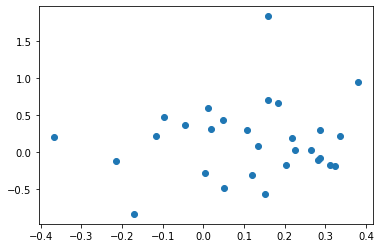

In [22]:
plt.scatter(df_merged.pct_change_adj_close, df_merged.pct_change_fund_size_amt)

In [23]:
df_merged['pct_change_adj_close'].corr(df_merged['avg_fund_size_amt'])

0.07250687220510116

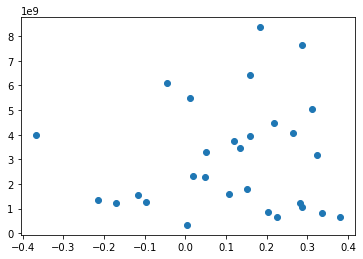

In [24]:
plt.scatter(df_merged.pct_change_adj_close, df_merged.avg_fund_size_amt)

In [25]:
df_merged['volatility'].corr(df_merged['pct_change_fund_size_amt'])

-0.09295513542178833

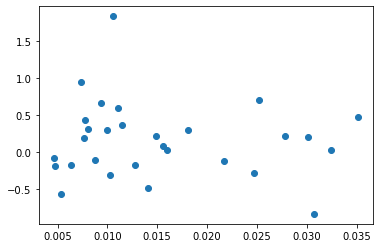

In [26]:
plt.scatter(df_merged.volatility, df_merged.pct_change_fund_size_amt)

In [27]:
df_merged['volatility'].corr(df_merged['avg_fund_size_amt'])

-0.3861680234575997

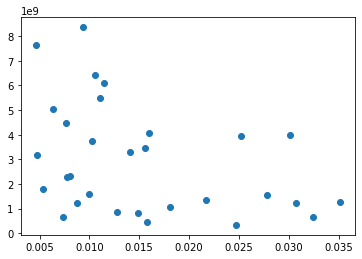

In [28]:
plt.scatter(df_merged.volatility, df_merged.avg_fund_size_amt)

In [29]:
df_merged['pct_change_adj_close'].corr(df_merged['pct_change_commit_amt'])

-0.019635452545019774

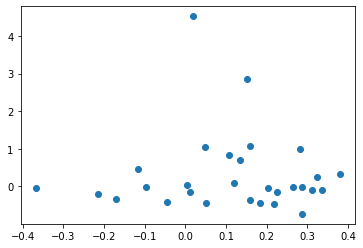

In [30]:
plt.scatter(df_merged.pct_change_adj_close, df_merged.pct_change_commit_amt)

In [31]:
df_merged['pct_change_adj_close'].corr(df_merged['avg_commit_amt'])

0.08788007257110932

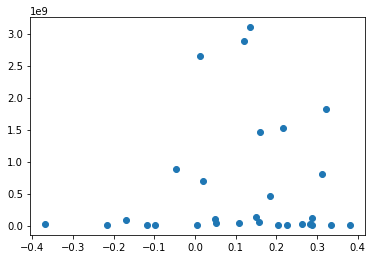

In [32]:
plt.scatter(df_merged.pct_change_adj_close, df_merged.avg_commit_amt)

In [33]:
df_merged['volatility'].corr(df_merged['pct_change_commit_amt'])

-0.215800967194689

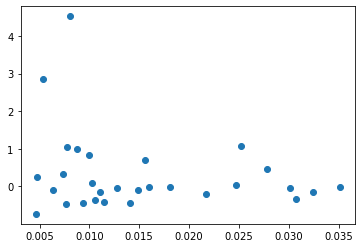

In [34]:
plt.scatter(df_merged.volatility, df_merged.pct_change_commit_amt)

In [35]:
df_merged['volatility'].corr(df_merged['avg_commit_amt'])

-0.2487675677977096

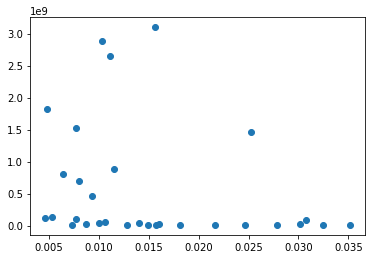

In [36]:
plt.scatter(df_merged.volatility, df_merged.avg_commit_amt)

In [37]:
df_merged.avg_fund_size_amt.nsmallest(5)

1    3.385642e+08
0    4.719266e+08
2    6.591820e+08
3    6.750360e+08
4    8.160065e+08
Name: avg_fund_size_amt, dtype: float64

#### Buyouts Funds (buyouts_funds_final.csv)

In [38]:
## retrying with year by year funds data

df_funds = pd.read_csv('buyouts_funds/buyouts_funds_csv/buyouts_funds_final.csv')
df_funds = df_funds.sort_values('vintage_year', ascending=False)
df_funds = df_funds[df_funds['vintage_year'] != 0]
df_funds.head()

,fund_id,fund_name,fm_id,strategy,sector,region,country,target_fund_size_amt,target_fund_size_currency,fund_size_amt,fund_currency,status,stage,vintage_year,open_date
6950,62131,Corridor Capital Title II,12869,Buyout / Corporate Private Equity,TMT,North America,NaN,NaN,NaN,13260000.0,USD,Launched,NaN,2022,2022-4
6177,61228,Altera Vision PA,22927,Venture Capital / Growth Equity,Diversified,North America,NaN,5250000.0,USD,3560000.0,USD,Currently Investing,1st Close,2022,2022-2
6193,61238,Third Lake PC NCBDC Fund,20727,Mezzanine / Debt,Diversified,North America,NaN,NaN,NaN,NaN,NaN,Launched,NaN,2022,2022-2
6192,61237,Barings CMS Fund,2161,Mezzanine / Debt,Diversified,North America,NaN,NaN,NaN,NaN,NaN,Launched,NaN,2022,2022-0
6189,61232,Perennial Private Growth Ventures Fund,22930,Venture Capital / Growth Equity,Diversified,Middle East/Africa,NaN,200000000.0,USD,NaN,NaN,Launched,NaN,2022,2022-3


In [39]:
df_funds = df_funds[['vintage_year', 'fund_size_amt', 'target_fund_size_amt']]
df_funds.head()

,vintage_year,fund_size_amt,target_fund_size_amt
6950,2022,13260000.0,NaN
6177,2022,3560000.0,5250000.0
6193,2022,NaN,NaN
6192,2022,NaN,NaN
6189,2022,NaN,200000000.0


In [40]:
df_funds_grouped = df_funds.groupby('vintage_year', as_index=False).agg({'fund_size_amt':'mean',
                                                                        'target_fund_size_amt':'mean'})
df_funds_grouped = df_funds_grouped.sort_values('vintage_year', ascending=False)
df_funds_grouped = df_funds_grouped.rename(columns={'vintage_year':'year', 'fund_size_amt':'avg_fund_size_amt',
                                                   'target_fund_size_amt':'avg_target_fund_size_amt'})
df_funds_grouped.head()

,year,avg_fund_size_amt,avg_target_fund_size_amt
3,2022,3.468283e+08,3.293141e+09
2,2021,8.073735e+08,1.833711e+09
1,2020,4.589803e+08,1.141979e+09
0,2019,1.436815e+09,3.027148e+08


In [41]:
## merge S&P data with funds data

df_merged2 = pd.merge(df_agg, df_funds_grouped, on='year')
df_merged2 = df_merged2.sort_values('year')
df_merged2.head()

,year,ret_high,ret_low,pct_change_adj_close,volatility,avg_fund_size_amt,avg_target_fund_size_amt
0,2019,0.359911,0.351552,0.312239,0.006370,1.436815e+09,3.027148e+08
1,2020,0.205324,0.194289,0.183316,0.009325,4.589803e+08,1.141979e+09
2,2021,0.296452,0.290498,0.287288,0.004625,8.073735e+08,1.833711e+09
3,2022,-0.146675,-0.172188,-0.170519,0.030758,3.468283e+08,3.293141e+09


In [42]:
## look at percent changes in allocation of funds

df_merged2['pct_change_fund_amt'] = df_merged2['avg_fund_size_amt'].pct_change()
df_merged2['pct_change_target_amt'] = df_merged2['avg_target_fund_size_amt'].pct_change()

df_merged2 = df_merged2[['year', 'ret_high', 'ret_low', 'pct_change_adj_close',
                      'volatility', 'avg_fund_size_amt', 'pct_change_fund_amt',
                      'avg_target_fund_size_amt', 'pct_change_target_amt']]

df_merged2.head()

,year,ret_high,ret_low,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt
0,2019,0.359911,0.351552,0.312239,0.006370,1.436815e+09,NaN,3.027148e+08,NaN
1,2020,0.205324,0.194289,0.183316,0.009325,4.589803e+08,-0.680557,1.141979e+09,2.772458
2,2021,0.296452,0.290498,0.287288,0.004625,8.073735e+08,0.759059,1.833711e+09,0.605731
3,2022,-0.146675,-0.172188,-0.170519,0.030758,3.468283e+08,-0.570424,3.293141e+09,0.795889


In [43]:
## percent changes for emerging funds in particular

df_emerging2 = df_merged2[df_merged2['avg_fund_size_amt'] <= 250000000]
df_emerging2.head()

,year,ret_high,ret_low,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt


##### No average fund size less than or equal to $250M in Funds data

In [44]:
## correlations

df_merged2['pct_change_adj_close'].corr(df_merged2['pct_change_fund_amt'])

0.6234590837464378

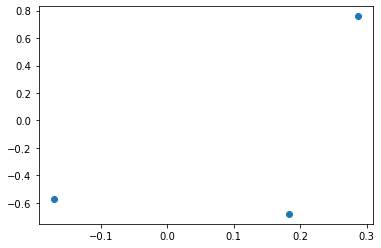

In [45]:
plt.scatter(df_merged2.pct_change_adj_close, df_merged2.pct_change_fund_amt)

In [46]:
df_merged2['pct_change_adj_close'].corr(df_merged2['avg_fund_size_amt'])

0.7279554094232358

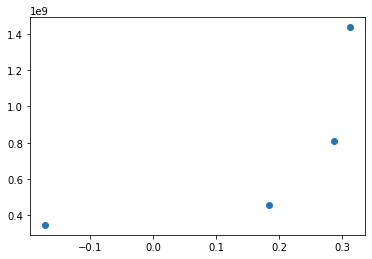

In [47]:
plt.scatter(df_merged2.pct_change_adj_close, df_merged2.avg_fund_size_amt)

In [48]:
df_merged2['volatility'].corr(df_merged2['pct_change_fund_amt'])

-0.5845520724135566

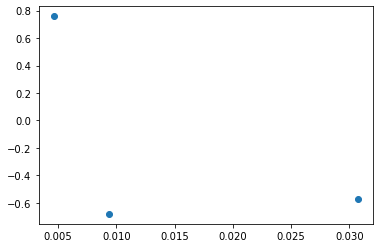

In [49]:
plt.scatter(df_merged2.volatility, df_merged2.pct_change_fund_amt)

In [50]:
df_merged2['volatility'].corr(df_merged2['avg_fund_size_amt'])

-0.6217189931930354

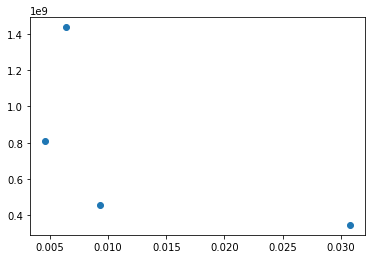

In [51]:
plt.scatter(df_merged2.volatility, df_merged2.avg_fund_size_amt)

In [52]:
df_merged2.avg_fund_size_amt.nsmallest(5)

3    3.468283e+08
1    4.589803e+08
2    8.073735e+08
0    1.436815e+09
Name: avg_fund_size_amt, dtype: float64

#### Buyouts Fund Manager History (buyouts_fm_fund_history.csv)

In [53]:
## retrying with year by year fund history data

df_fund_hist = pd.read_csv('buyouts_funds/buyouts_funds_csv/buyouts_fm_fund_history.csv')
df_fund_hist = df_fund_hist.sort_values('vintage_year', ascending=False)
df_fund_hist = df_fund_hist[df_fund_hist['vintage_year'] != 0]
df_fund_hist.head()

,fm_fund_id,fm_id,fund_id,fund_name,vintage_year,region,sector,strategy,fund_size_amt,fund_currency,target_fund_size_amt,target_fund_size_currency
28568,14887,6373,60838,Apax XI,2022,Western Europe,Healthcare,Buyout / Corporate Private Equity,0.0,USD,1.300000e+10,USD
16926,12203,20421,62041,Imaginary Venture Capital EIP Fund III,2022,North America,TMT,Venture Capital / Growth Equity,2250000.0,USD,3.000000e+06,USD
25878,12592,7918,61341,NVP X,2022,North America,Diversified,Fund of Funds / Co-Investment,58120000.0,USD,2.000000e+08,USD
25877,8189,7918,61341,NVP X,2022,Asia-Pacific,Diversified,Fund of Funds / Co-Investment,58120000.0,USD,2.000000e+08,USD
1481,81,19359,60588,Two Sigma Ventures Opportunity Fund II,2022,North America,TMT,Venture Capital / Growth Equity,0.0,USD,0.000000e+00,USD


In [54]:
df_fund_hist = df_fund_hist[['vintage_year', 'fund_size_amt', 'target_fund_size_amt']]
df_fund_hist.head()

,vintage_year,fund_size_amt,target_fund_size_amt
28568,2022,0.0,1.300000e+10
16926,2022,2250000.0,3.000000e+06
25878,2022,58120000.0,2.000000e+08
25877,2022,58120000.0,2.000000e+08
1481,2022,0.0,0.000000e+00


In [55]:
df_fund_hist_grouped = df_fund_hist.groupby('vintage_year', as_index=False).agg({'fund_size_amt':'mean',
                                                                        'target_fund_size_amt':'mean'})
df_fund_hist_grouped = df_fund_hist_grouped.sort_values('vintage_year', ascending=False)
df_fund_hist_grouped = df_fund_hist_grouped.rename(columns={'vintage_year':'year',
                                                            'fund_size_amt':'avg_fund_size_amt',
                                                   'target_fund_size_amt':'avg_target_fund_size_amt'})
df_fund_hist_grouped.head()

,year,avg_fund_size_amt,avg_target_fund_size_amt
46,2022,1.229488e+08,1.721153e+09
45,2021,8.103145e+08,1.178290e+09
44,2020,9.503080e+08,9.747711e+08
43,2019,2.318471e+09,1.208510e+09
42,2018,1.510733e+09,1.245684e+09


In [56]:
## merge S&P data with funds data

df_merged3 = pd.merge(df_agg, df_fund_hist_grouped, on='year')
df_merged3 = df_merged3.sort_values('year')
df_merged3.head()

,year,ret_high,ret_low,pct_change_adj_close,volatility,avg_fund_size_amt,avg_target_fund_size_amt
0,1993,NaN,NaN,NaN,0.015753,5.014138e+08,1.360795e+08
1,1994,0.665287,0.640533,0.003974,0.024656,2.476874e+08,1.454302e+08
2,1995,1.206738,1.196651,0.380489,0.007307,4.990383e+08,2.676641e+07
3,1996,0.958165,0.918385,0.224974,0.032474,3.518425e+08,5.550826e+07
4,1997,1.070409,1.050526,0.334752,0.014896,6.744599e+08,2.132325e+08


In [57]:
## look at percent changes in allocation of funds

df_merged3['pct_change_fund_amt'] = df_merged3['avg_fund_size_amt'].pct_change()
df_merged3['pct_change_target_amt'] = df_merged3['avg_target_fund_size_amt'].pct_change()

df_merged3 = df_merged3[['year', 'ret_high', 'ret_low', 'pct_change_adj_close',
                      'volatility', 'avg_fund_size_amt', 'pct_change_fund_amt',
                      'avg_target_fund_size_amt', 'pct_change_target_amt']]

df_merged3.head()

,year,ret_high,ret_low,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt
0,1993,NaN,NaN,NaN,0.015753,5.014138e+08,NaN,1.360795e+08,NaN
1,1994,0.665287,0.640533,0.003974,0.024656,2.476874e+08,-0.506022,1.454302e+08,0.068715
2,1995,1.206738,1.196651,0.380489,0.007307,4.990383e+08,1.014791,2.676641e+07,-0.815950
3,1996,0.958165,0.918385,0.224974,0.032474,3.518425e+08,-0.294959,5.550826e+07,1.073803
4,1997,1.070409,1.050526,0.334752,0.014896,6.744599e+08,0.916937,2.132325e+08,2.841455


In [58]:
## percent changes for emerging funds in particular

df_emerging3 = df_merged3[df_merged3['avg_fund_size_amt'] <= 250000000]
df_emerging3.head()

,year,ret_high,ret_low,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt
1,1994,0.665287,0.640533,0.003974,0.024656,2.476874e+08,-0.506022,1.454302e+08,0.068715
29,2022,-0.146675,-0.172188,-0.170519,0.030758,1.229488e+08,-0.848270,1.721153e+09,0.460721


##### Average fund sizes in both 1994 and 2022 are the lowest 

In [59]:
## correlations

df_merged3['pct_change_adj_close'].corr(df_merged3['pct_change_fund_amt'])

0.14356006959583786

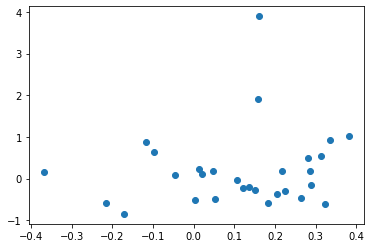

In [60]:
plt.scatter(df_merged3.pct_change_adj_close, df_merged3.pct_change_fund_amt)

In [61]:
df_merged3['pct_change_adj_close'].corr(df_merged3['avg_fund_size_amt'])

0.006328702696983285

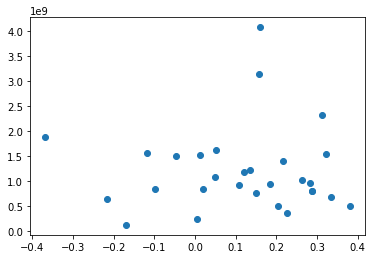

In [62]:
plt.scatter(df_merged3.pct_change_adj_close, df_merged3.avg_fund_size_amt)

In [63]:
df_merged3['volatility'].corr(df_merged3['pct_change_fund_amt'])

0.10399003920576727

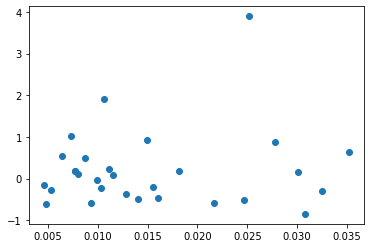

In [64]:
plt.scatter(df_merged3.volatility, df_merged3.pct_change_fund_amt)

In [65]:
df_merged3['volatility'].corr(df_merged3['avg_fund_size_amt'])

-0.055441179109785604

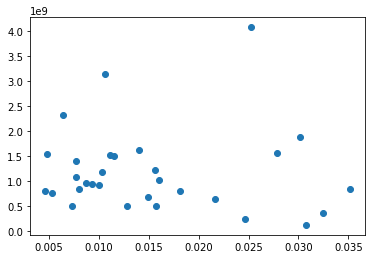

In [66]:
plt.scatter(df_merged3.volatility, df_merged3.avg_fund_size_amt)

#### Buyouts Historical Data (buyouts_historical_funds.csv)

In [67]:
## retrying with year by year fund history data

df_hist = pd.read_csv('buyouts_funds/buyouts_funds_csv/buyouts_historical_funds.csv')
df_hist = df_hist.sort_values('close_year', ascending=False)
df_hist = df_hist[df_hist['close_year'] != 0]
df_hist.head()

,fund_id,fund_name,manager_id,manager,close_year,strategy,fund_size_amt,fund_currency
7158,59510,Coral Tree Fund I,22607.0,Coral Tree Partners,2022,Venture Capital / Growth Equity,450000000.0,USD
7064,61899,Fuse Venture Partners Alpha I,7015.0,Ignition Partners,2022,Venture Capital / Growth Equity,159660000.0,USD
7070,61821,Signal Peak Ventures III CIV-A,12537.0,Signal Peak Ventures,2022,Venture Capital / Growth Equity,50960000.0,USD
7069,61796,Frazier Life Sciences XI,6498.0,Frazier Healthcare Partners,2022,Venture Capital / Growth Equity,960000000.0,USD
7068,62028,Legacy Knight Strategic Opportunities Fund,22886.0,Legacy Knight,2022,Venture Capital / Growth Equity,72620000.0,USD


In [68]:
df_hist = df_hist[['close_year', 'fund_size_amt']]
df_hist.head()

,close_year,fund_size_amt
7158,2022,450000000.0
7064,2022,159660000.0
7070,2022,50960000.0
7069,2022,960000000.0
7068,2022,72620000.0


In [69]:
df_hist_grouped = df_hist.groupby('close_year', as_index=False).agg({'fund_size_amt':'mean'})
df_hist_grouped = df_hist_grouped.sort_values('close_year', ascending=False)
df_hist_grouped = df_hist_grouped.rename(columns={'close_year':'year', 'fund_size_amt':'avg_fund_size_amt'})
df_hist_grouped.head()

,year,avg_fund_size_amt
41,2022,6.614948e+08
40,2021,4.060309e+08
39,2020,2.631996e+08
38,2019,2.745854e+08
37,2018,2.299908e+08


In [70]:
## merge S&P data with fund history data

df_merged4 = pd.merge(df_agg, df_hist_grouped, on='year')
df_merged4 = df_merged4.sort_values('year')
df_merged4.head()

,year,ret_high,ret_low,pct_change_adj_close,volatility,avg_fund_size_amt
0,1993,NaN,NaN,NaN,0.015753,1.617220e+08
1,1994,0.665287,0.640533,0.003974,0.024656,2.250000e+08
2,1995,1.206738,1.196651,0.380489,0.007307,1.640000e+08
3,1996,0.958165,0.918385,0.224974,0.032474,1.462857e+08
4,1997,1.070409,1.050526,0.334752,0.014896,3.365350e+08


In [71]:
## look at percent changes in allocation of funds

df_merged4['pct_change_fund_amt'] = df_merged4['avg_fund_size_amt'].pct_change()

df_merged4 = df_merged4[['year', 'ret_high', 'ret_low', 'pct_change_adj_close',
                      'volatility', 'avg_fund_size_amt', 'pct_change_fund_amt']]

df_merged4.head()

,year,ret_high,ret_low,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt
0,1993,NaN,NaN,NaN,0.015753,1.617220e+08,NaN
1,1994,0.665287,0.640533,0.003974,0.024656,2.250000e+08,0.391276
2,1995,1.206738,1.196651,0.380489,0.007307,1.640000e+08,-0.271111
3,1996,0.958165,0.918385,0.224974,0.032474,1.462857e+08,-0.108014
4,1997,1.070409,1.050526,0.334752,0.014896,3.365350e+08,1.300532


In [72]:
## percent changes for emerging funds in particular

df_emerging4 = df_merged4[df_merged4['avg_fund_size_amt'] <= 250000000]
df_emerging4

,year,ret_high,ret_low,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt
0,1993,NaN,NaN,NaN,0.015753,1.617220e+08,NaN
1,1994,0.665287,0.640533,0.003974,0.024656,2.250000e+08,0.391276
2,1995,1.206738,1.196651,0.380489,0.007307,1.640000e+08,-0.271111
3,1996,0.958165,0.918385,0.224974,0.032474,1.462857e+08,-0.108014
5,1998,0.969234,0.945897,0.286924,0.018134,1.941444e+08,-0.423108
9,2002,0.138655,0.121659,-0.215846,0.021675,1.664290e+08,-0.394498
10,2003,0.831235,0.820069,0.281816,0.008711,1.964729e+08,0.180521
11,2004,0.558524,0.547507,0.106979,0.009952,2.278578e+08,0.159741
18,2011,0.246063,0.237876,0.018950,0.008035,1.942770e+08,-0.521571
19,2012,0.379997,0.350763,0.159903,0.025204,2.333471e+08,0.201105


In [73]:
## correlations

df_merged4['pct_change_adj_close'].corr(df_merged4['pct_change_fund_amt'])

0.02279863557873984

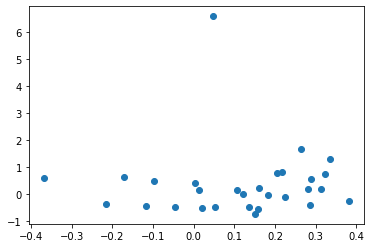

In [74]:
plt.scatter(df_merged4.pct_change_adj_close, df_merged4.pct_change_fund_amt)

In [75]:
df_merged4['pct_change_adj_close'].corr(df_merged4['avg_fund_size_amt'])

-0.058391598215112236

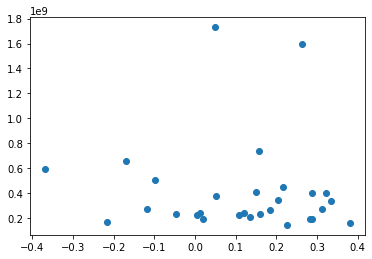

In [76]:
plt.scatter(df_merged4.pct_change_adj_close, df_merged4.avg_fund_size_amt)

In [77]:
df_merged4['volatility'].corr(df_merged4['pct_change_fund_amt'])

-0.09961749515416334

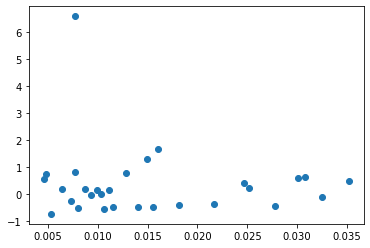

In [78]:
plt.scatter(df_merged4.volatility, df_merged4.pct_change_fund_amt)

In [79]:
df_merged4['volatility'].corr(df_merged4['avg_fund_size_amt'])

-0.03997458194335998

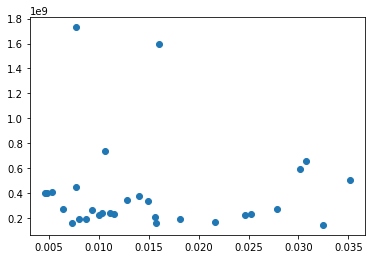

In [80]:
plt.scatter(df_merged4.volatility, df_merged4.avg_fund_size_amt)

In [81]:
## correlations for emerging funds only

df_emerging4['pct_change_adj_close'].corr(df_emerging4['pct_change_fund_amt'])

0.11223063012550955

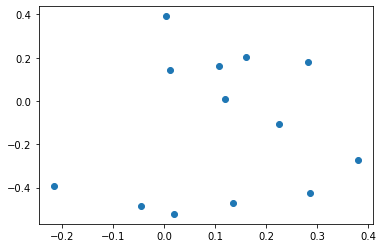

In [82]:
plt.scatter(df_emerging4.pct_change_adj_close, df_emerging4.pct_change_fund_amt)

In [83]:
df_emerging4['pct_change_adj_close'].corr(df_emerging4['avg_fund_size_amt'])

-0.2506289408774063

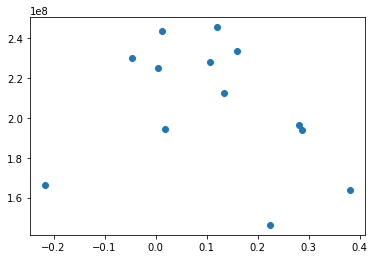

In [84]:
plt.scatter(df_emerging4.pct_change_adj_close, df_emerging4.avg_fund_size_amt)

In [85]:
df_emerging4['volatility'].corr(df_emerging4['pct_change_fund_amt'])

0.18717831014210873

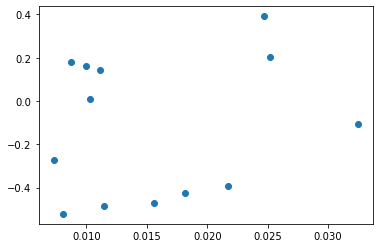

In [86]:
plt.scatter(df_emerging4.volatility, df_emerging4.pct_change_fund_amt)

In [87]:
df_emerging4['volatility'].corr(df_emerging4['avg_fund_size_amt'])

-0.283828584820825

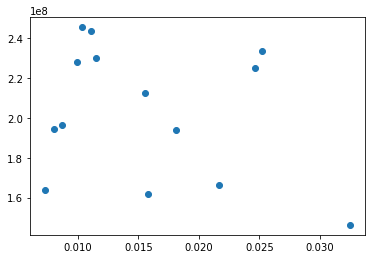

In [88]:
plt.scatter(df_emerging4.volatility, df_emerging4.avg_fund_size_amt)

##### Greater correlation between S&P data and emerging funds specifically

### Linear Regression: S&P vs. LP Commitments (lp_commitments.csv)

In [89]:
df_merged

,year,ret_high,ret_low,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_size_amt,avg_commit_amt,pct_change_commit_amt
0,1993,NaN,NaN,NaN,0.015753,4.719266e+08,NaN,1.149871e+07,NaN
1,1994,0.665287,0.640533,0.003974,0.024656,3.385642e+08,-0.282591,1.182192e+07,0.028109
2,1995,1.206738,1.196651,0.380489,0.007307,6.591820e+08,0.946992,1.560681e+07,0.320158
3,1996,0.958165,0.918385,0.224974,0.032474,6.750360e+08,0.024051,1.330191e+07,-0.147685
4,1997,1.070409,1.050526,0.334752,0.014896,8.160065e+08,0.208834,1.211518e+07,-0.089215
5,1998,0.969234,0.945897,0.286924,0.018134,1.055814e+09,0.293880,1.185049e+07,-0.021847
6,1999,0.821099,0.805666,0.203894,0.012819,8.717311e+08,-0.174352,1.145844e+07,-0.033083
7,2000,0.377111,0.345383,-0.097415,0.035152,1.279754e+09,0.468061,1.126401e+07,-0.016968
8,2001,0.322456,0.297913,-0.117585,0.027813,1.553750e+09,0.214100,1.636040e+07,0.452449
9,2002,0.138655,0.121659,-0.215846,0.021675,1.364562e+09,-0.121762,1.297006e+07,-0.207229


In [90]:
# using all variables to predict pct_change_fund_size_amt

df_merged.dropna(inplace=True)

model_lp1 = LinearRegression()

#X_lp1 = df_merged.loc[:, df_merged.columns != 'pct_change_fund_size_amt']
X_lp1 = df_merged[['year', 'ret_high', 'ret_low', 'pct_change_adj_close', 'volatility']]
y_lp1 = df_merged.pct_change_fund_size_amt

model_lp1.fit(X_lp1, y_lp1)

rsq_model_lp1 = model_lp1.score(X_lp1, y_lp1)
rsq_model_lp1

0.06007732440563196

In [91]:
# verify p-value

x_prime = sm.add_constant(X_lp1)
model_lp1_ols = sm.OLS(y_lp1, X_lp1)
res_lp1 = model_lp1_ols.fit()
res_lp1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     pct_change_fund_size_amt   R-squared (uncentered):                   0.137
Model:                                  OLS   Adj. R-squared (uncentered):             -0.043
Method:                       Least Squares   F-statistic:                             0.7611
Date:                      Sat, 28 May 2022   Prob (F-statistic):                       0.587
Time:                              16:46:14   Log-Likelihood:                         -20.461
No. Observations:                        29   AIC:                                      50.92
Df Residuals:                            24   BIC:                                      57.76
Df Model:                                 5                                                  
Covariance Type:                  nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                     0.0001      0.000      0.680      0.503      -0.000       0.000
ret_high                28.7312     64.545      0.445      0.660    -104.484     161.946
ret_low                -28.3018     64.603     -0.438      0.665    -161.636     105.032
pct_change_adj_close    -1.0537      1.626     -0.648      0.523      -4.409       2.302
volatility             -39.2184     70.798     -0.554      0.585    -185.339     106.902
==============================================================================
Omnibus:                        9.817   Durbin-Watson:                   2.508
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                8.742
Skew:                           0.994   Prob(JB):                       0.0126
Kurtosis:                       4.812   Cond. No.                     2.31e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [92]:
X_lp2 = df_merged[['year', 'pct_change_adj_close', 'volatility']]

x_prime = sm.add_constant(X_lp2)
model_lp1_ols = sm.OLS(y_lp1, X_lp2)
res_lp1 = model_lp1_ols.fit()
res_lp1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     pct_change_fund_size_amt   R-squared (uncentered):                   0.100
Model:                                  OLS   Adj. R-squared (uncentered):             -0.004
Method:                       Least Squares   F-statistic:                             0.9605
Date:                      Sat, 28 May 2022   Prob (F-statistic):                       0.426
Time:                              16:46:15   Log-Likelihood:                         -21.071
No. Observations:                        29   AIC:                                      48.14
Df Residuals:                            26   BIC:                                      52.24
Df Model:                                 3                                                  
Covariance Type:                  nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                  7.468e-05      0.000      0.550      0.587      -0.000       0.000
pct_change_adj_close     0.2841      0.670      0.424      0.675      -1.094       1.662
volatility              -1.7813     13.325     -0.134      0.895     -29.172      25.610
==============================================================================
Omnibus:                       10.368   Durbin-Watson:                   2.341
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                9.878
Skew:                           0.983   Prob(JB):                      0.00716
Kurtosis:                       5.076   Cond. No.                     2.73e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### weak $\left\lvert t \right\rvert$ and p-values and corresponding relatively low $R^{2}$

### Linear Regression: S&P vs. Buyouts Fund Manager History (buyouts_fm_fund_history.csv)

In [93]:
df_merged3

,year,ret_high,ret_low,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt
0,1993,NaN,NaN,NaN,0.015753,5.014138e+08,NaN,1.360795e+08,NaN
1,1994,0.665287,0.640533,0.003974,0.024656,2.476874e+08,-0.506022,1.454302e+08,0.068715
2,1995,1.206738,1.196651,0.380489,0.007307,4.990383e+08,1.014791,2.676641e+07,-0.815950
3,1996,0.958165,0.918385,0.224974,0.032474,3.518425e+08,-0.294959,5.550826e+07,1.073803
4,1997,1.070409,1.050526,0.334752,0.014896,6.744599e+08,0.916937,2.132325e+08,2.841455
5,1998,0.969234,0.945897,0.286924,0.018134,7.971730e+08,0.181943,1.598099e+08,-0.250537
6,1999,0.821099,0.805666,0.203894,0.012819,5.103882e+08,-0.359752,6.490265e+07,-0.593876
7,2000,0.377111,0.345383,-0.097415,0.035152,8.341124e+08,0.634271,2.451806e+08,2.777667
8,2001,0.322456,0.297913,-0.117585,0.027813,1.563546e+09,0.874503,3.085000e+08,0.258256
9,2002,0.138655,0.121659,-0.215846,0.021675,6.409040e+08,-0.590096,2.676473e+08,-0.132424


In [94]:
# using all variables to predict pct_change_fund_amt

df_merged3.dropna(inplace=True)

model_fm1 = LinearRegression()

X_fm1 = df_merged3[['year', 'ret_high', 'ret_low', 'pct_change_adj_close', 'volatility']]
y_fm1 = df_merged3.pct_change_fund_amt

model_fm1.fit(X_fm1, y_fm1)

rsq_model_fm1 = model_fm1.score(X_fm1, y_fm1)
rsq_model_fm1

0.09695440787561127

In [95]:
# verify p-value

x_prime_fm1 = sm.add_constant(X_fm1)
model_fm1 = sm.OLS(y_fm1, X_fm1)
res_fm1 = model_fm1.fit()
res_fm1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     pct_change_fund_amt   R-squared (uncentered):                   0.118
Model:                             OLS   Adj. R-squared (uncentered):             -0.066
Method:                  Least Squares   F-statistic:                             0.6430
Date:                 Sat, 28 May 2022   Prob (F-statistic):                       0.669
Time:                         16:46:15   Log-Likelihood:                         -37.432
No. Observations:                   29   AIC:                                      84.86
Df Residuals:                       24   BIC:                                      91.70
Df Model:                            5                                                  
Covariance Type:             nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                    -0.0002      0.000     -0.593      0.559      -0.001       0.000
ret_high                24.5905    115.880      0.212      0.834    -214.574     263.755
ret_low                -24.7022    115.984     -0.213      0.833    -264.081     214.676
pct_change_adj_close     1.2921      2.919      0.443      0.662      -4.733       7.317
volatility               3.8692    127.106      0.030      0.976    -258.465     266.203
==============================================================================
Omnibus:                       23.211   Durbin-Watson:                   2.334
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.225
Skew:                           1.778   Prob(JB):                     3.04e-09
Kurtosis:                       7.452   Cond. No.                     2.31e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [96]:
X_fm2 = df_merged3[['ret_high', 'ret_low', 'volatility']]

x_prime_fm2 = sm.add_constant(X_fm2)
model_fm1 = sm.OLS(y_fm1, X_fm2)
res_fm1 = model_fm1.fit()
res_fm1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     pct_change_fund_amt   R-squared (uncentered):                   0.105
Model:                             OLS   Adj. R-squared (uncentered):              0.002
Method:                  Least Squares   F-statistic:                              1.016
Date:                 Sat, 28 May 2022   Prob (F-statistic):                       0.401
Time:                         16:46:15   Log-Likelihood:                         -37.647
No. Observations:                   29   AIC:                                      81.29
Df Residuals:                       26   BIC:                                      85.40
Df Model:                            3                                                  
Covariance Type:             nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ret_high      66.5061     76.673      0.867      0.394     -91.098     224.110
ret_low      -66.6050     77.181     -0.863      0.396    -225.253      92.043
volatility   -52.1072     67.860     -0.768      0.449    -191.596      87.381
==============================================================================
Omnibus:                       24.758   Durbin-Watson:                   2.467
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.631
Skew:                           1.893   Prob(JB):                     3.35e-10
Kurtosis:                       7.667   Cond. No.                         578.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Linear Regression: S&P vs. Buyouts Historical Data (buyouts_historical_funds.csv)

In [97]:
df_merged4

,year,ret_high,ret_low,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt
0,1993,NaN,NaN,NaN,0.015753,1.617220e+08,NaN
1,1994,0.665287,0.640533,0.003974,0.024656,2.250000e+08,0.391276
2,1995,1.206738,1.196651,0.380489,0.007307,1.640000e+08,-0.271111
3,1996,0.958165,0.918385,0.224974,0.032474,1.462857e+08,-0.108014
4,1997,1.070409,1.050526,0.334752,0.014896,3.365350e+08,1.300532
5,1998,0.969234,0.945897,0.286924,0.018134,1.941444e+08,-0.423108
6,1999,0.821099,0.805666,0.203894,0.012819,3.440412e+08,0.772089
7,2000,0.377111,0.345383,-0.097415,0.035152,5.022335e+08,0.459806
8,2001,0.322456,0.297913,-0.117585,0.027813,2.748611e+08,-0.452722
9,2002,0.138655,0.121659,-0.215846,0.021675,1.664290e+08,-0.394498


In [98]:
# using all variables to predict pct_change_fund_amt

df_merged4.dropna(inplace=True)

model_hist1 = LinearRegression()

X_hist1 = df_merged[['year', 'ret_high', 'ret_low', 'pct_change_adj_close', 'volatility']]
y_hist1 = df_merged4.pct_change_fund_amt

model_hist1.fit(X_hist1, y_hist1)

rsq_model_hist1 = model_hist1.score(X_hist1, y_hist1)
rsq_model_hist1

0.024224664501398374

In [99]:
# verify p-value

x_prime_hist1 = sm.add_constant(X_hist1)
model_hist1 = sm.OLS(y_hist1, X_hist1)
res_hist1 = model_hist1.fit()
res_hist1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     pct_change_fund_amt   R-squared (uncentered):                   0.092
Model:                             OLS   Adj. R-squared (uncentered):             -0.098
Method:                  Least Squares   F-statistic:                             0.4839
Date:                 Sat, 28 May 2022   Prob (F-statistic):                       0.785
Time:                         16:46:15   Log-Likelihood:                         -48.718
No. Observations:                   29   AIC:                                      107.4
Df Residuals:                       24   BIC:                                      114.3
Df Model:                            5                                                  
Covariance Type:             nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                     0.0003      0.000      0.766      0.451      -0.001       0.001
ret_high                -3.8902    171.010     -0.023      0.982    -356.838     349.058
ret_low                  4.6225    171.163      0.027      0.979    -348.641     357.886
pct_change_adj_close    -1.6179      4.308     -0.376      0.711     -10.509       7.273
volatility             -25.2750    187.577     -0.135      0.894    -412.416     361.866
==============================================================================
Omnibus:                       46.559   Durbin-Watson:                   2.352
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              222.603
Skew:                           3.175   Prob(JB):                     4.60e-49
Kurtosis:                      14.996   Cond. No.                     2.31e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [100]:
X_hist2 = df_merged[['year', 'pct_change_adj_close']]

x_prime_hist2 = sm.add_constant(X_hist2)
model_hist1 = sm.OLS(y_hist1, X_hist2)
res_hist1 = model_hist1.fit()
res_hist1.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     pct_change_fund_amt   R-squared (uncentered):                   0.070
Model:                             OLS   Adj. R-squared (uncentered):              0.001
Method:                  Least Squares   F-statistic:                              1.012
Date:                 Sat, 28 May 2022   Prob (F-statistic):                       0.377
Time:                         16:46:15   Log-Likelihood:                         -49.062
No. Observations:                   29   AIC:                                      102.1
Df Residuals:                       27   BIC:                                      104.9
Df Model:                            2                                                  
Covariance Type:             nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                     0.0002      0.000      1.141      0.264      -0.000       0.000
pct_change_adj_close     0.1676      1.404      0.119      0.906      -2.713       3.048
==============================================================================
Omnibus:                       53.111   Durbin-Watson:                   2.295
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.890
Skew:                           3.657   Prob(JB):                     1.04e-71
Kurtosis:                      17.733   Cond. No.                     1.11e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### weak results

### Linear Regression: S&P vs. Buyouts Historical Data Emerging Funds (buyouts_historical_funds.csv)

In [101]:
df_emerging4

,year,ret_high,ret_low,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt
0,1993,NaN,NaN,NaN,0.015753,1.617220e+08,NaN
1,1994,0.665287,0.640533,0.003974,0.024656,2.250000e+08,0.391276
2,1995,1.206738,1.196651,0.380489,0.007307,1.640000e+08,-0.271111
3,1996,0.958165,0.918385,0.224974,0.032474,1.462857e+08,-0.108014
5,1998,0.969234,0.945897,0.286924,0.018134,1.941444e+08,-0.423108
9,2002,0.138655,0.121659,-0.215846,0.021675,1.664290e+08,-0.394498
10,2003,0.831235,0.820069,0.281816,0.008711,1.964729e+08,0.180521
11,2004,0.558524,0.547507,0.106979,0.009952,2.278578e+08,0.159741
18,2011,0.246063,0.237876,0.018950,0.008035,1.942770e+08,-0.521571
19,2012,0.379997,0.350763,0.159903,0.025204,2.333471e+08,0.201105


In [102]:
# using all variables to predict pct_change_fund_amt

df_emerging4.dropna(inplace=True)

model_hist_em1 = LinearRegression()

X_hist_em1 = df_emerging4[['year', 'ret_high', 'ret_low', 'pct_change_adj_close', 'volatility']]
y_hist_em1 = df_emerging4.pct_change_fund_amt

model_hist_em1.fit(X_hist_em1, y_hist_em1)

rsq_model_hist_em1 = model_hist_em1.score(X_hist_em1, y_hist_em1)
rsq_model_hist_em1

/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


0.14342389535278866

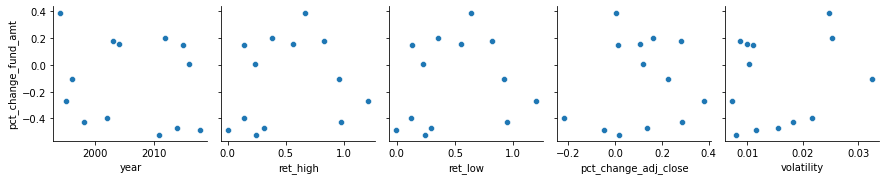

In [110]:
sns.pairplot(df_emerging4, x_vars=['year', 'ret_high', 'ret_low', 'pct_change_adj_close', 'volatility'],
            y_vars='pct_change_fund_amt')

In [ ]:
# verify p-value

x_prime_hist_em1 = sm.add_constant(X_hist_em1)
model_hist_em1 = sm.OLS(y_hist_em1, X_hist_em1)
res_hist_em1 = model_hist_em1.fit()
res_hist_em1.summary()

In [ ]:
X_hist_em2 = df_emerging4[['year', 'pct_change_adj_close']]

x_prime_hist_em2 = sm.add_constant(X_hist_em2)
model_hist_em1 = sm.OLS(y_hist_em1, X_hist_em2)
res_hist_em1 = model_hist_em1.fit()
res_hist_em1.summary()

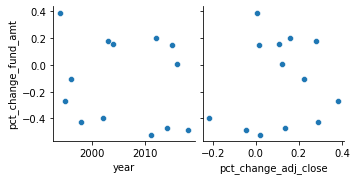

In [111]:
sns.pairplot(df_emerging4, x_vars=['year', 'pct_change_adj_close'],
            y_vars='pct_change_fund_amt')

##### weak results

### [ignore] historical S&P data, 1978-2022

In [268]:
df_sp = pd.read_csv('HistoricalPrices1978.csv')
df_sp

,Date,Open,High,Low,Close
0,05/11/22,3990.08,4049.09,3928.82,3935.18
1,05/10/22,4035.18,4068.82,3958.17,4001.05
2,05/09/22,4081.27,4081.27,3975.48,3991.24
3,05/06/22,4128.17,4157.69,4067.91,4123.34
4,05/05/22,4270.43,4270.43,4106.01,4146.87
...,...,...,...,...,...
11181,01/09/78,90.64,91.52,90.01,90.64
11182,01/06/78,91.62,92.66,91.05,91.62
11183,01/05/78,92.74,94.53,92.51,92.74
11184,01/04/78,93.52,94.10,93.16,93.52


In [269]:
df_sp[["day", "month", "year"]] = df_sp["Date"].str.split("/", expand = True)
df_sp.head()

,Date,Open,High,Low,Close,day,month,year
0,05/11/22,3990.08,4049.09,3928.82,3935.18,05,11,22
1,05/10/22,4035.18,4068.82,3958.17,4001.05,05,10,22
2,05/09/22,4081.27,4081.27,3975.48,3991.24,05,09,22
3,05/06/22,4128.17,4157.69,4067.91,4123.34,05,06,22
4,05/05/22,4270.43,4270.43,4106.01,4146.87,05,05,22


In [270]:
df_sp = df_sp.rename(columns={'Date':'date', ' Open':'open', ' High':'high', ' Low':'low',
                             ' Close':'close'})
df_sp.head()

,date,open,high,low,close,day,month,year
0,05/11/22,3990.08,4049.09,3928.82,3935.18,05,11,22
1,05/10/22,4035.18,4068.82,3958.17,4001.05,05,10,22
2,05/09/22,4081.27,4081.27,3975.48,3991.24,05,09,22
3,05/06/22,4128.17,4157.69,4067.91,4123.34,05,06,22
4,05/05/22,4270.43,4270.43,4106.01,4146.87,05,05,22


In [271]:
df_sp['avg_open_yr'] = df_sp.groupby(df_sp['year'])['open'].transform('mean')
df_sp['avg_high_yr'] = df_sp.groupby(df_sp['year'])['high'].transform('mean')
df_sp['avg_low_yr'] = df_sp.groupby(df_sp['year'])['low'].transform('mean')
df_sp.head()

,date,open,high,low,close,day,month,year,avg_open_yr,avg_high_yr,avg_low_yr
0,05/11/22,3990.08,4049.09,3928.82,3935.18,05,11,22,4423.340444,4458.361111,4374.597222
1,05/10/22,4035.18,4068.82,3958.17,4001.05,05,10,22,4423.340444,4458.361111,4374.597222
2,05/09/22,4081.27,4081.27,3975.48,3991.24,05,09,22,4423.340444,4458.361111,4374.597222
3,05/06/22,4128.17,4157.69,4067.91,4123.34,05,06,22,4423.340444,4458.361111,4374.597222
4,05/05/22,4270.43,4270.43,4106.01,4146.87,05,05,22,4423.340444,4458.361111,4374.597222


In [272]:
df_sp_yr = df_sp[['year', 'avg_open_yr', 'avg_high_yr', 'avg_low_yr']]
df_sp_yr.head()

,year,avg_open_yr,avg_high_yr,avg_low_yr
0,22,4423.340444,4458.361111,4374.597222
1,22,4423.340444,4458.361111,4374.597222
2,22,4423.340444,4458.361111,4374.597222
3,22,4423.340444,4458.361111,4374.597222
4,22,4423.340444,4458.361111,4374.597222


In [273]:
df_sp_final = df_sp_yr.drop_duplicates()
df_sp_final

,year,avg_open_yr,avg_high_yr,avg_low_yr
0,22,4423.340444,4458.361111,4374.597222
90,21,4271.170714,4291.877579,4251.042698
342,20,3217.750277,3242.183953,3190.484466
595,19,2911.627619,2923.622341,2899.439921
847,18,2747.784900,2762.655418,2730.275259
1098,17,2448.275896,2454.344821,2441.850677
1349,16,2094.091548,2103.306865,2083.753135
1601,15,2061.268016,2071.863095,2049.309524
1853,14,1930.754484,1938.835595,1922.292976
2105,13,1642.295516,1649.615714,1635.737024


In [274]:
df_sp_final['year'] = df_sp_final['year'].astype(int)

/var/folders/_7/h5pf_y9106z75mck2bx53gqw0000gn/T/ipykernel_37432/2375293518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp_final['year'] = df_sp_final['year'].astype(int)


In [275]:
df_sp_final.dtypes

year             int64
avg_open_yr    float64
avg_high_yr    float64
avg_low_yr     float64
dtype: object

In [278]:
years = df_sp_final['year'].values.tolist()

In [279]:
converted_yrs = []

for i in years:
    if i <= 23:
        i+=2000
        converted_yrs.append(i)
    else:
        i+=1900
        converted_yrs.append(i)

In [280]:
df_sp_final['converted_years'] = converted_yrs
df_sp_final = df_sp_final[['converted_years', 'avg_open_yr', 'avg_high_yr', 'avg_low_yr']]
df_sp_final.head()

/var/folders/_7/h5pf_y9106z75mck2bx53gqw0000gn/T/ipykernel_37432/1249340593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp_final['converted_years'] = converted_yrs


,converted_years,avg_open_yr,avg_high_yr,avg_low_yr
0,2022,4423.340444,4458.361111,4374.597222
90,2021,4271.170714,4291.877579,4251.042698
342,2020,3217.750277,3242.183953,3190.484466
595,2019,2911.627619,2923.622341,2899.439921
847,2018,2747.784900,2762.655418,2730.275259


### [ignore] buyouts: funds

In [281]:
df_funds = pd.read_csv('buyouts_funds/buyouts_funds_csv/buyouts_funds_final.csv')
df_funds.head()

,fund_id,fund_name,fm_id,strategy,sector,region,country,target_fund_size_amt,target_fund_size_currency,fund_size_amt,fund_currency,status,stage,vintage_year,open_date
0,34866,Ascent Venture Partners VII,6381,Venture Capital / Growth Equity,TMT,North America,United States,150000000.0,USD,NaN,NaN,Launched,NaN,2020,2020-0
1,36284,Fall Line Endurance Fund (Open-Ended),15168,Venture Capital / Growth Equity,TMT,North America,United States,NaN,NaN,285000000.0,USD,Currently Investing,NaN,2019,2016-7
2,36284,Fall Line Endurance Fund (Open-Ended),15168,Venture Capital / Growth Equity,Agribusiness,North America,United States,NaN,NaN,285000000.0,USD,Currently Investing,NaN,2019,2016-7
3,39769,Star Mountain U.S. LMM Secondary Fund II,1671,Secondaries,Diversified,North America,United States,500000000.0,USD,200000000.0,USD,Currently Investing,1st Close,2020,2020-12
4,43372,Waterfall Sentinel Fund I,19136,Buyout / Corporate Private Equity,Diversified,North America,United States,300000000.0,USD,80000000.0,USD,Currently Investing,1st Close,2019,2019-1


In [282]:
df_funds = df_funds.sort_values('vintage_year', ascending=False)
df_funds.head()

,fund_id,fund_name,fm_id,strategy,sector,region,country,target_fund_size_amt,target_fund_size_currency,fund_size_amt,fund_currency,status,stage,vintage_year,open_date
6950,62131,Corridor Capital Title II,12869,Buyout / Corporate Private Equity,TMT,North America,NaN,NaN,NaN,13260000.0,USD,Launched,NaN,2022,2022-4
6177,61228,Altera Vision PA,22927,Venture Capital / Growth Equity,Diversified,North America,NaN,5250000.0,USD,3560000.0,USD,Currently Investing,1st Close,2022,2022-2
6193,61238,Third Lake PC NCBDC Fund,20727,Mezzanine / Debt,Diversified,North America,NaN,NaN,NaN,NaN,NaN,Launched,NaN,2022,2022-2
6192,61237,Barings CMS Fund,2161,Mezzanine / Debt,Diversified,North America,NaN,NaN,NaN,NaN,NaN,Launched,NaN,2022,2022-0
6189,61232,Perennial Private Growth Ventures Fund,22930,Venture Capital / Growth Equity,Diversified,Middle East/Africa,NaN,200000000.0,USD,NaN,NaN,Launched,NaN,2022,2022-3


In [283]:
df_funds.tail()

,fund_id,fund_name,fm_id,strategy,sector,region,country,target_fund_size_amt,target_fund_size_currency,fund_size_amt,fund_currency,status,stage,vintage_year,open_date
570,49113,Spire Capital Partners IV,7103,Buyout / Corporate Private Equity,TMT,North America,NaN,NaN,NaN,291550000.0,USD,Currently Investing,2nd Close,2019,2019-11
569,49113,Spire Capital Partners IV,7103,Buyout / Corporate Private Equity,Business Services,North America,NaN,NaN,NaN,291550000.0,USD,Currently Investing,2nd Close,2019,2019-11
568,49075,Elephant Partners III,16906,Venture Capital / Growth Equity,TMT,North America,United States,350000000.0,USD,NaN,NaN,Currently Investing,1st Close,2019,2019-11
567,49057,RCP Small & Emerging Fund II,1780,Fund of Funds / Co-Investment,Diversified,North America,United States,200000000.0,USD,123230000.0,USD,Currently Investing,5th Close,2019,2019-11
3475,56899,Renegade Partners I,22225,Venture Capital / Growth Equity,TMT,North America,NaN,300000000.0,USD,100000000.0,USD,Currently Investing,1st Close,2019,2020-3


### [ignore] buyouts: LP commitments

In [284]:
df_lp = pd.read_csv('buyouts_lp/buyouts_lp_csv/lp_commitments.csv')
df_lp.head()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
0,215027,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Asia-Pacific,2011
1,195565,3,60421,Greenspring Global Partners V,7045,StepStone Group,TMT,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Asia-Pacific,2011
2,181373,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Latin America,2011
3,125752,3,60421,Greenspring Global Partners V,7045,StepStone Group,TMT,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Latin America,2011
4,88550,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Western Europe,2011


In [285]:
df_lp = df_lp.sort_values('vintage_year', ascending=False)
df_lp.head()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
243986,162760,22750,60617,Genesia Venture Fund III,19397,Genesia Ventures,TMT,Venture Capital / Growth Equity,1.000000e+10,JPY,NaN,NaN,Asia-Pacific,2022
41802,230179,302,60838,Apax XI,6373,Apax Partners,TMT,Buyout / Corporate Private Equity,0.000000e+00,USD,100000000.0,USD,Middle East/Africa,2022
41818,984,302,60920,Blackstone Growth II,5611,Blackstone,TMT,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41817,90581,302,60920,Blackstone Growth II,5611,Blackstone,Healthcare,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41816,151888,302,60920,Blackstone Growth II,5611,Blackstone,Consumer Goods,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022


In [286]:
df_lp = df_lp[df_lp['vintage_year'] != 0]
df_lp.head()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
243986,162760,22750,60617,Genesia Venture Fund III,19397,Genesia Ventures,TMT,Venture Capital / Growth Equity,1.000000e+10,JPY,NaN,NaN,Asia-Pacific,2022
41802,230179,302,60838,Apax XI,6373,Apax Partners,TMT,Buyout / Corporate Private Equity,0.000000e+00,USD,100000000.0,USD,Middle East/Africa,2022
41818,984,302,60920,Blackstone Growth II,5611,Blackstone,TMT,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41817,90581,302,60920,Blackstone Growth II,5611,Blackstone,Healthcare,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41816,151888,302,60920,Blackstone Growth II,5611,Blackstone,Consumer Goods,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022


In [287]:
df_lp.tail()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
42682,103572,314,15212,New Enterprise Associates I,6610,New Enterprise Associates,Healthcare,Venture Capital / Growth Equity,16000000.0,USD,72000.0,USD,North America,1978
42683,11756,314,15212,New Enterprise Associates I,6610,New Enterprise Associates,TMT,Venture Capital / Growth Equity,16000000.0,USD,72000.0,USD,North America,1978
84678,169189,542,15212,New Enterprise Associates I,6610,New Enterprise Associates,Healthcare,Venture Capital / Growth Equity,16000000.0,USD,50000000.0,USD,North America,1978
217369,131578,14598,25103,Charles River II,6429,CRV,Diversified,Venture Capital / Growth Equity,6800000.0,USD,NaN,NaN,North America,1976
224583,221613,15532,25103,Charles River II,6429,CRV,Diversified,Venture Capital / Growth Equity,6800000.0,USD,NaN,NaN,North America,1976


In [288]:
#df_lp['avg_fund_size_amt'] = df_lp.groupby("vintage_year")['fund_size_amt'].transform('mean')
#df_lp.head()

In [289]:
df_lp_grouped = df_lp.groupby('vintage_year',as_index=False).agg({'fund_size_amt':'mean', 'commitment_amt':'mean'})
df_lp_grouped

,vintage_year,fund_size_amt,commitment_amt
0,1976,6.800000e+06,NaN
1,1978,1.600000e+07,1.835733e+07
2,1979,3.135000e+07,2.000000e+06
3,1980,7.699545e+07,4.332000e+07
4,1981,3.552000e+07,3.865455e+07
5,1982,3.815125e+08,7.548600e+06
6,1983,1.448451e+08,1.641667e+07
7,1984,1.040575e+08,1.113846e+07
8,1985,1.138329e+08,1.055661e+07
9,1986,5.510820e+08,7.628571e+06


In [290]:
df_lp_grouped = df_lp_grouped.sort_values('vintage_year', ascending=False)
df_lp_grouped

,vintage_year,fund_size_amt,commitment_amt
45,2022,1.228527e+09,8.287198e+07
44,2021,7.623665e+09,1.242416e+08
43,2020,8.361854e+09,4.629961e+08
42,2019,5.044311e+09,8.095592e+08
41,2018,6.090554e+09,8.848151e+08
40,2017,4.472146e+09,1.530681e+09
39,2016,3.757126e+09,2.885293e+09
38,2015,5.490946e+09,2.654402e+09
37,2014,3.444918e+09,3.099146e+09
36,2013,3.186252e+09,1.828307e+09


In [291]:
df_lp_grouped = df_lp_grouped.rename(columns={'fund_size_amt':'avg_fund_size_amt', 
                                              'commitment_amt':'avg_commitment_amt'})
df_lp_grouped

,vintage_year,avg_fund_size_amt,avg_commitment_amt
45,2022,1.228527e+09,8.287198e+07
44,2021,7.623665e+09,1.242416e+08
43,2020,8.361854e+09,4.629961e+08
42,2019,5.044311e+09,8.095592e+08
41,2018,6.090554e+09,8.848151e+08
40,2017,4.472146e+09,1.530681e+09
39,2016,3.757126e+09,2.885293e+09
38,2015,5.490946e+09,2.654402e+09
37,2014,3.444918e+09,3.099146e+09
36,2013,3.186252e+09,1.828307e+09


In [292]:
#df_lp['avg_fund_size_amt'] = df_lp.groupby('vintage_year').agg({'fund_size_amt':'mean', 
                                                               #'commitment_amt':'mean'})


In [293]:
#df_lp_final = df_lp_grouped.drop_duplicates(subset=['vintage_year', 'avg_fund_size_amt'])
#df_lp_final

### [ignore] S&P + LP commitments

In [294]:
df_lp_merge = df_lp_grouped.rename(columns={'vintage_year':'year'})
df_sp_merge = df_sp_final.rename(columns={'converted_years':'year', 'avg_open_yr':'avg_open',
                                         'avg_high_yr':'avg_high', 'avg_low_yr':'avg_low'})
df_merged = pd.merge(df_sp_merge, df_lp_merge, on='year')
df_merged = df_merged.sort_values('year')
df_merged

,year,avg_open,avg_high,avg_low,avg_fund_size_amt,avg_commitment_amt
44,1978,96.117778,96.801190,95.438214,1.600000e+07,1.835733e+07
43,1979,102.980833,103.474048,102.436111,3.135000e+07,2.000000e+06
42,1980,118.713913,119.416403,117.958182,7.699545e+07,4.332000e+07
41,1981,128.038142,129.355968,126.784427,3.552000e+07,3.865455e+07
40,1982,119.705494,121.041107,118.405652,3.815125e+08,7.548600e+06
39,1983,160.473043,161.929091,158.898933,1.448451e+08,1.641667e+07
38,1984,160.463636,161.312885,159.679289,1.040575e+08,1.113846e+07
37,1985,186.828175,187.415754,186.064524,1.138329e+08,1.055661e+07
36,1986,236.391858,237.463913,234.950356,5.510820e+08,7.628571e+06
35,1987,286.995889,289.283439,284.524190,7.904181e+08,2.796233e+07


In [295]:
df_merged['avg_high'].corr(df_merged['avg_fund_size_amt'])

0.7632889955588487

In [296]:
df_merged['avg_low'].corr(df_merged['avg_fund_size_amt'])

0.7649360242313832

In [297]:
df_merged['avg_high'].corr(df_merged['avg_commitment_amt'])

0.39660694898994586

In [298]:
df_merged['avg_low'].corr(df_merged['avg_commitment_amt'])

0.39935689323545853

In [299]:
X = df_merged[['year', 'avg_open', 'avg_high', 'avg_low', 'avg_commitment_amt']]
y = df_merged.avg_fund_size_amt

In [300]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [301]:
pipe = make_pipeline(Lasso(alpha=100, max_iter=1000))

In [302]:
lasso = pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.320289729290673e+19, tolerance: 1.95323112580764e+16
  model = cd_fast.enet_coordinate_descent(


In [303]:
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso['lasso'].coef_ != 0))

Test set score: 0.80
Number of features used: 5


In [304]:
X2 = df_merged[['year', 'avg_open', 'avg_high', 'avg_commitment_amt']]

In [305]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.1, random_state=0)

In [306]:
lasso2 = pipe.fit(X_train2, y_train2)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3510501794343813e+19, tolerance: 1.95323112580764e+16
  model = cd_fast.enet_coordinate_descent(


In [307]:
print("Test set score: {:.2f}".format(lasso2.score(X_test2, y_test2)))
print("Number of features used:", np.sum(lasso2['lasso'].coef_ != 0))

Test set score: 0.81
Number of features used: 4


In [308]:
X3 = df_merged[['avg_open', 'avg_high', 'avg_commitment_amt']]

In [309]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.1, random_state=0)

In [310]:
lasso3 = pipe.fit(X_train3, y_train3)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.916409427215324e+19, tolerance: 1.95323112580764e+16
  model = cd_fast.enet_coordinate_descent(


In [311]:
print("Test set score: {:.2f}".format(lasso3.score(X_test3, y_test3)))
print("Number of features used:", np.sum(lasso3['lasso'].coef_ != 0))

Test set score: 0.72
Number of features used: 3


In [312]:
param_grid={'lasso__alpha': np.logspace(1,7,num=13),
           'lasso__max_iter': [10000]}

In [313]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=10, n_jobs=-1)

In [314]:
grid.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8195043507480035e+19, tolerance: 1.5590305779438276e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9409855358124528e+19, tolerance: 1.8669686279674744e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.035362651104777e+19, tolerance: 1.8894652170089156e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.818828162710499e+19, tolerance: 1.5590305779438276e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9610222260645085e+19, tolerance: 1.8502517141135704e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.954960628472115e+19, tolerance: 1.872979959097456e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

GridSearchCV(cv=10, estimator=Pipeline(steps=[('lasso', Lasso(alpha=100))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05, 3.16227766e+05, 1.00000000e+06, 3.16227766e+06,
       1.00000000e+07]),
                         'lasso__max_iter': [10000]})

In [315]:
print("Score for the best model: {:.2f}".format(grid.score(X_test, y_test)))

Score for the best model: 0.75


In [316]:
grid.best_params_

{'lasso__alpha': 10000000.0, 'lasso__max_iter': 10000}

In [317]:
grid.best_estimator_

Pipeline(steps=[('lasso', Lasso(alpha=10000000.0, max_iter=10000))])